## SAC: discrete action, simplified

soft actor-critic

最大化动作的熵,增强模型的稳定性

$$
Q(s, a) + α \text{Entropy}[Q(s, *)]
$$

训练时$α$固定，并且只用一个Value模型评估Q函数

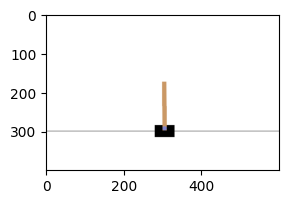

In [12]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [13]:
import torch
	
# 演员模型：计算动作概率
model_action = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
	torch.nn.Softmax(dim=1),
)
model_action(torch.randn(2, 4))

tensor([[0.5228, 0.4772],
        [0.5143, 0.4857]], grad_fn=<SoftmaxBackward0>)

In [14]:
model_value = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)

model_value_next = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 2),
)


model_value_next.load_state_dict(model_value.state_dict())
model_value(torch.randn(2, 4))

tensor([[-0.0789, -0.1394],
        [-0.0782, -0.1270]], grad_fn=<AddmmBackward0>)

In [24]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据环境采样
    prob = model_action(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
    action = random.choices(range(2), weights=prob, k=1)[0]

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

  if show:
    display.clear_output(wait=True)
    env.show()

  return data, reward_sum

play()[-1]

196.0

In [16]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return len(self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      self.pool.extend(play()[0])
      
    # 保留最新N条数据
    self.pool = self.pool[-2_0000:]
    
  def sample(self):
    data = random.sample(self.pool, 64)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over
  
pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()
len(pool), pool[0]

(300,
 (array([-0.04091163, -0.01071781, -0.03632788, -0.00824241], dtype=float32),
  0,
  1.0,
  array([-0.04112599, -0.20530045, -0.03649273,  0.27276093], dtype=float32),
  False))

In [17]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=2e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=2e-3)


def soft_update(_from, _to):
  for _from, _to in zip(_from.parameters(), _to.parameters()):
    value = _to.data * 0.995 + _from.data * 0.005
    _to.data.copy_(value)
    
def get_prob_entroy(state):
  prob = model_action(torch.FloatTensor(state).reshape(-1, 4))
  entropy = prob * (prob + 1e-8).log()
  entropy = -entropy.sum(dim=1, keepdim=True)
  
  return prob, entropy
    
def requires_grad(model, value):
  for param in model.parameters():
    param.requires_grad_(value)
    
alpha = 1.0

In [18]:
# critic 模型训练
def train_value(state, action, reward, next_state, over):
  requires_grad(model_value, True)
  requires_grad(model_action, False)
  
  # 计算targets
  with torch.no_grad():
    # 计算动作熵
    prob, entropy = get_prob_entroy(next_state)
    target = model_value_next(next_state)
    
  # 加权熵，越大越好
  target = (prob * target).sum(dim=1, keepdim=True)
  target = target + 1e-3 * entropy
  target = target * 0.98 * (1 - over) + reward
  
  # 计算value
  value = model_value(state).gather(dim=1, index=action)
  loss = torch.nn.functional.mse_loss(value, target)
  loss.backward()
  optimizer_value.step()
  optimizer_value.zero_grad()
  
  return loss.item()

train_value(state, action, reward, next_state, over)

1.0024724006652832

In [19]:
# 训练actor
def train_action(state):
  requires_grad(model_action, True)
  requires_grad(model_value, False)
  
  # 计算熵
  prob, entropy = get_prob_entroy(state)
  
  # 计算value
  value = model_value(state)
  
  # 求期望和
  value = (prob * value).sum(dim=1, keepdim=True)
  
  # 加权熵
  loss = -(value + 1e-3 * entropy).mean()
  
  loss.backward()
  optimizer_action.step()
  optimizer_action.zero_grad()
  
  return loss.item()

train_action(state)

-0.02478880062699318

In [20]:
#训练
def train():
  model_action.train()
  model_value.train()

	# 共更新N轮数据
  for epoch in range(200):
    # 更新N条数据
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 训练
      train_value(state, action, reward, next_state, over)
      train_action(state)
      soft_update(model_value, model_value_next)

    if epoch % 10 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), alpha, test_result)

train()

0 507 1.0 21.45
10 3221 1.0 164.1
20 6358 1.0 182.25
30 9475 1.0 173.7
40 12545 1.0 175.35
50 15406 1.0 184.6
60 18131 1.0 198.05
70 20000 1.0 193.0
80 20000 1.0 190.5
90 20000 1.0 54.7
100 20000 1.0 200.0
110 20000 1.0 133.15
120 20000 1.0 102.9
130 20000 1.0 99.6
140 20000 1.0 96.85
150 20000 1.0 100.7
160 20000 1.0 107.95
170 20000 1.0 126.2
180 20000 1.0 170.1
190 20000 1.0 142.65


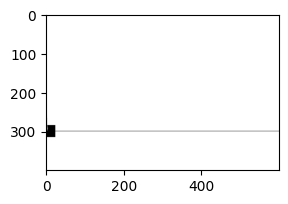

181.0

In [25]:
play(True)[-1]